In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

2024-10-23 12:34:50.378116: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Path

In [2]:
train_dir = '/Users/kuriankgeorge/Desktop/aws/Capstone/05_Mood_Music/data/MoodforMusic/train'
test_dir = '/Users/kuriankgeorge/Desktop/aws/Capstone/05_Mood_Music/data/MoodforMusic/test'

Image generator

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    horizontal_flip=True,  
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Use 128x128 for faster training
    batch_size=32,  # Slightly larger batch size for efficiency
    class_mode='categorical',
    subset='training'
)

Found 22968 images belonging to 7 classes.


In [5]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5741 images belonging to 7 classes.


Use mobilenetv2

In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [7]:
for layer in base_model.layers[:-10]:  # Only fine-tune the last 10 layers
    layer.trainable = False

In [8]:
# Add new layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling for fewer parameters
x = Dense(256, activation='relu')(x)  
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # 7 classes for mood detection

model = Model(inputs=base_model.input, outputs=predictions)

Compile

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

Early stopping

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Train the model

In [11]:
history = model.fit(
    train_generator,
    epochs=10, 
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 400s 543ms/step - accuracy: 0.3288 - loss: 1.7746 - val_accuracy: 0.3888 - val_loss: 1.6081
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 390s 542ms/step - accuracy: 0.4849 - loss: 1.3595 - val_accuracy: 0.4402 - val_loss: 1.4428
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 387s 539ms/step - accuracy: 0.5347 - loss: 1.2441 - val_accuracy: 0.4778 - val_loss: 1.3534
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 389s 541ms/step - accuracy: 0.5640 - loss: 1.1628 - val_accuracy: 0.5231 - val_loss: 1.2760
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 381s 530ms/step - accuracy: 0.5836 - loss: 1.1121 - val_accuracy: 0.5332 - val_loss: 1.2602
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 383s 531ms/step - accuracy: 0.6055 - loss: 1.0621 - val_accuracy: 0.5384 - val_loss: 1.2523
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 441s 530ms/step - accuracy: 0.6368 - loss: 0.9909 - val_accuracy: 0.5377 - val_loss: 1.2587
Epoch 8/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 382s 530ms/step - accuracy: 0.6575 - loss: 0.93

In [12]:
model.save('fast_mood_classifier_model.h5')

In [23]:
import matplotlib.pyplot as plt

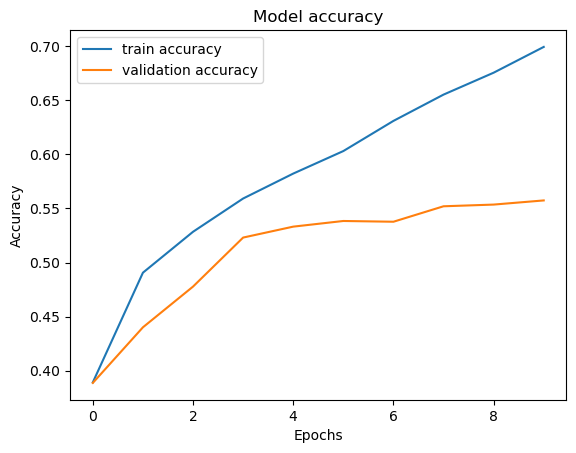

In [24]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

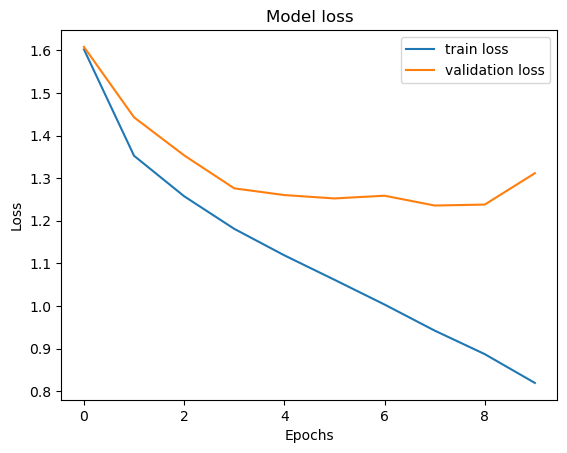

In [25]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load the saved model
model = load_model('fast_mood_classifier_model.h5')

# Path to test data directory
test_dir = '/Users/kuriankgeorge/Desktop/aws/Capstone/05_Mood_Music/data/MoodforMusic/test'

# Create a test data generator with rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow test images from directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict the mood labels for the test images
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class indices from the test generator
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Print a sample of predicted and true classes
for i in range(10):
    print(f"True label: {class_labels[true_classes[i]]}, Predicted: {class_labels[predicted_classes[i]]}")

Found 7178 images belonging to 7 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 87s 375ms/step - accuracy: 0.4948 - loss: 1.3943
Test Loss: 1.2112550735473633
Test Accuracy: 0.5568403601646423
225/225 ━━━━━━━━━━━━━━━━━━━━ 88s 387ms/step
True label: angry, Predicted: sad
True label: angry, Predicted: angry
True label: angry, Predicted: sad
True label: angry, Predicted: sad
True label: angry, Predicted: happy
True label: angry, Predicted: angry
True label: angry, Predicted: neutral
True label: angry, Predicted: angry
True label: angry, Predicted: happy
True label: angry, Predicted: angry


Musis recommendation

In [13]:
import pandas as pd
import random

In [14]:
music_data=pd.read_csv("/Users/kuriankgeorge/Desktop/aws/Capstone/05_Mood_Music/data/MoodforMusic/data_moods.csv")

A function to recommend music based on detected mood

In [15]:
def recommend_music(mood):
    # Filter music based on mood
    filtered_data = music_data[music_data['mood'] == mood]
    
    # Recommend a random song from the filtered data
    if not filtered_data.empty:
        recommended_song = filtered_data.sample()
        return {
            'name': recommended_song['name'].values[0],
            'artist': recommended_song['artist'].values[0],
            'album': recommended_song['album'].values[0]
        }
    else:
        return None

In [20]:
detected_mood = 'Happy'  
song = recommend_music(detected_mood)
if song:
    print(f"Recommended Song: {song['name']} by {song['artist']} from the album {song['album']}")
else:
    print("No songs found for the given mood.")

Recommended Song: Crazy Horses by The Osmonds from the album Crazy Horses
